In [87]:
import os
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import from_networkx
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import copy 

In [89]:
torch.manual_seed(1234567)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]


folder_path = 'client_subgraphs'
sub_data_list = []
client_number = []

for filename in os.listdir(folder_path):
    if filename.endswith('.gml'):
      
        file_path = os.path.join(folder_path, filename)
        g = nx.read_gml(file_path)

        subgraph_nodes = list(g.nodes)
        subgraph_nodes = [int(node) for node in subgraph_nodes]  # Convert to integer if they are not

        sub_edge_index, _ = subgraph(subgraph_nodes, data.edge_index, relabel_nodes=True)

        sub_data = Data(x=data.x[subgraph_nodes], edge_index=sub_edge_index, y=data.y[subgraph_nodes])
        sub_data_list.append(sub_data)
        client_number.append(int(filename.split('.')[0].split('_')[1]))
        


In [90]:
test_data = None

g = nx.read_gml('test_graph.gml')
subgraph_nodes = list(g.nodes)
subgraph_nodes = [int(node) for node in subgraph_nodes]  # Convert to integer if they are not
sub_edge_index, _ = subgraph(subgraph_nodes, data.edge_index, relabel_nodes=True)
test_data = Data(x=data.x[subgraph_nodes], edge_index=sub_edge_index, y=data.y[subgraph_nodes])



In [91]:

g = nx.read_gml('new_facebook_network.gml')
neighbors = {}

for node in g.nodes:
    neighbors[node] = list(g.neighbors(node))

print(neighbors)

{'828': ['713', '705', '719', '805', '824', '745', '747', '823', '694', '830', '781', '697', '724', '827', '688', '853', '834', '703', '784', '815', '752', '728', '820', '842', '800', '819', '774', '726', '773', '766', '829', '780', '810', '696', '849', '718', '754', '760', '739', '856', '764', '687', '840', '847', '770', '797', '814', '727', '731', '708', '698', '817', '792', '845', '838', '848', '835', '807', '711', '779', '706', '772', '741', '709', '778', '737', '844', '693'], '713': ['828', '705', '719', '805', '824', '745', '747', '823', '694', '830', '781', '697', '724', '827', '688', '853', '834', '695', '784', '815', '752', '842', '800', '819', '774', '726', '773', '766', '829', '780', '810', '696', '760', '787', '840', '847', '814', '731', '708', '698', '738', '817', '734', '845', '701', '848', '748', '706', '777', '772', '818', '778', '831', '833', '722', '844', '736', '794', '693'], '705': ['828', '713', '719', '805', '824', '745', '747', '823', '694', '830', '781', '697', 

In [92]:
# read new_facebook_network.gml and create a fully connected graph

neighbors_fully_connected = {}

for node in g.nodes:
    neighbors_fully_connected[node] = list(g.nodes)
    neighbors_fully_connected[node].remove(node)

    
# print(neighbors_fully_connected)

In [93]:
print(sub_data_list[0])
print(sub_data_list[0].x.shape)
print(type(client_number))

Data(x=[18, 1433], edge_index=[2, 58], y=[18])
torch.Size([18, 1433])
<class 'list'>


In [94]:
#keep a  list of training and validation loss per epoch for each subgraph
train_losses = []
val_losses = []

In [95]:
import torch



def transductive_split(data, train_percent=0.8, val_percent=0.1):
    """
    Split graph data into training, validation, and testing sets for transductive learning.
    :param data: PyG Data object
    :param train_percent: Percentage of nodes to be used for training
    :param val_percent: Percentage of nodes to be used for validation
    :return: data object with train_mask, val_mask, and test_mask attributes added
    """
    # set a seed for reproducibility

    num_nodes = data.num_nodes
    train_size = int(train_percent * num_nodes)
    val_size = int(val_percent * num_nodes)

    # Create a random permutation of node indices
    perm = torch.randperm(num_nodes)

    # Create masks for training, validation, and testing nodes
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[perm[:train_size]] = True
    val_mask[perm[train_size:train_size + val_size]] = True
    test_mask[perm[train_size + val_size:]] = True

    # Add masks to data object
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data


In [10]:
# splitting the subgraphs into train test and val 
# for i in range(0, 100):
#     sub_data = sub_data_list[i]
#     sub_data = transductive_split(sub_data)


# print(torch.sum(sub_data_list[4].train_mask).item())  # Number of training nodes
# print(torch.sum(sub_data_list[4].val_mask).item())    # Number of validation nodes
# print(torch.sum(sub_data_list[4].test_mask).item()) 

In [96]:
from torch_geometric.nn import GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   
    
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) # p = 0.25
        x = self.conv2(x, edge_index)
        return x
    


model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)

In [97]:
import matplotlib.pyplot as plt

# fig, axs = plt.subplots(10, 10, figsize=(50, 50))

def train(sub_data, model, optimizer, criterion):
      model.train()
      optimizer.zero_grad() 
      out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
      loss = criterion(out, sub_data.y)  # Compute the loss solely based on the training nodes.
      loss.backward() 
      optimizer.step() 
      return loss

def test(test_data, criterion, model):
      model.eval()
      out = model(test_data.x, test_data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred == test_data.y # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / len(test_data.y)  # Derive ratio of correct predictions.
      test_loss = criterion(out, test_data.y)  # Compute validation loss
      
      return test_loss, test_acc


def validate(test_data, model, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not compute gradients during this step
        out = model(test_data.x, test_data.edge_index)  # Forward pass
        pred = out.argmax(dim=1)  # Get predicted classes
        val_correct = pred == test_data.y # Compare with ground-truth
        val_loss = criterion(out, test_data.y)  # Compute validation loss
        val_acc = int(val_correct.sum()) / int(len(test_data.y))  # Compute validation accuracy
    return val_loss.item(), val_acc  # Return validation loss and accuracy


def initial_training(epochs):
    test_losses = []
    test_accs = []
    dictionary_t_1 = {}
    dictionary_t = {}

    for i in range(len(sub_data_list)):
        sub_data = sub_data_list[i]
        
        model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_losses = [] 
        val_losses = []    

        # Training loop for each epoch (adjust the range as needed)
        for epoch in range(1, epochs + 1):
            train_loss = train(sub_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
            val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
        
        test_loss, test_acc = test(test_data, criterion, model)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        row = i // 10
        col = i % 10

        model_weights = model.state_dict()
        client_number_num = client_number[i]
        dictionary_t_1[client_number_num] = model_weights
        
    # plt.tight_layout()
    # plt.show()
    
    return dictionary_t_1, test_losses, test_accs
    
    


In [98]:
dictionary_t_1, test_losses, test_accs = initial_training(10)

# average test loss and accuracy before communication 

mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

mean test loss before communication:  2.3276490342617033
mean test accuracy before communication:  0.14737142857142846


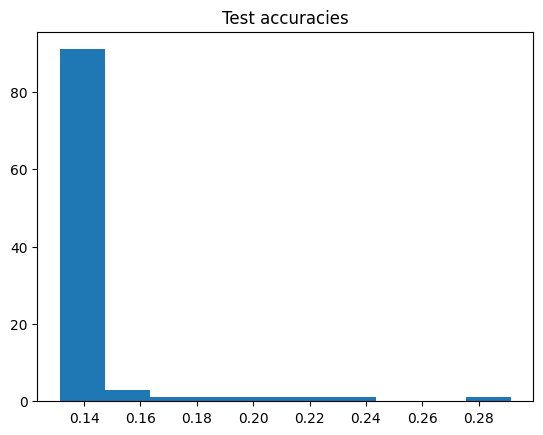

In [99]:

import matplotlib.pyplot as plt

plt.hist(test_accs)
plt.title("Test accuracies")
plt.show()

In [100]:
def fed_avg(models):
    global_model = copy.deepcopy(models[0]) # start with the first model
    for k in global_model.keys():
        global_model[k] = torch.stack([model[k].float() for model in models], 0).mean(0)
    return global_model

In [101]:
def communication(dictionary_t_1_og, neighbors, epochs, rounds):
    # make a copy of dictionary_t_1
    test_losses = []
    test_accs = []
    
    dictionary_t_1 = dictionary_t_1_og.copy()
    dictionary_t = {}
    for k in range(1, rounds + 1):

    # get the neighbprs of each client
        for i in range(len(sub_data_list)):
            sub_data = sub_data_list[i]
            
            model = GCN(sub_data.num_node_features, dataset.num_classes).to(device)
            model.load_state_dict(dictionary_t_1[client_number[i]])
            
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            train_losses = [] 
            val_losses = []    

            # Training loop for each epoch (adjust the range as needed)
            for epoch in range(1, epochs + 1):
                train_loss = train(sub_data, model, optimizer, criterion)  # Assuming 'train' returns a loss
                val_loss, _ = validate(test_data, model, criterion)         # Assuming 'validate' returns a loss and something else (like accuracy)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
            
            test_loss, test_acc = test(test_data, criterion, model)
            if k == rounds:
                test_losses.append(test_loss.item())
                test_accs.append(test_acc)

        
            # add the model weights to the t -1 dictionary
            model_weights = model.state_dict()
            client_number_num = client_number[i]
            dictionary_t_1[client_number_num] = model_weights
        

        for i in range(100):
            client_number_num = client_number[i]
            # go through neighbors of client_number
            string_client_num = str(client_number_num)
            client_neighbors = neighbors[string_client_num]
            
            neighbors_state_dicts = []
            neighbors_state_dicts.append(dictionary_t_1[client_number_num])
            for j in range(len(client_neighbors)):
                # get model weights of neighbor
                neighbor_model = dictionary_t_1[int(client_neighbors[j])]
                neighbors_state_dicts.append(neighbor_model)
            
            #call fed_avg
            average_state_dict = {}
            average_state_dict = fed_avg(neighbors_state_dicts)
            # average weights of client and neighbors
            # average_state_dict = {}
            # for param in neighbors_state_dicts[0]:
            #     # num parameters
            #     num_neighbors = len(neighbors_state_dicts)
            #     sum_param = 0
            #     for neighbor in range(num_neighbors):
            #         sum_param += neighbors_state_dicts[neighbor][param]
            #     average_param = sum_param / num_neighbors
            #     average_state_dict[param] = average_param
                
                
            dictionary_t[client_number_num] = average_state_dict    
            
        dictionary_t_1 = dictionary_t

    return test_losses, test_accs
 
        
         

In [25]:

test_losses, test_accs = communication(dictionary_t_1, neighbors, 10, 10)

# average test loss and accuracy after communication
mean_test_losses = sum(test_losses)/len(test_losses)

#mean of test_accs
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)


mean test loss after communication:  3.1825060403347014
mean test accuracy after communication:  0.14697142857142848


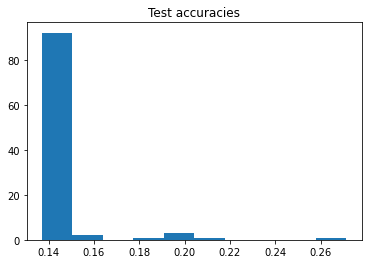

In [26]:
# print a distriution of the accuracies of test_losses and test_accs

import matplotlib.pyplot as plt

plt.hist(test_accs)
plt.title("Test accuracies")
plt.show()

In [ ]:
# pr

# Fully Connected Graph

## 1 epoch, 100 rounds

In [27]:
# 1 epoch

dictionary_t_1, test_losses, test_accs = initial_training(1)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors_fully_connected, 1, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)


mean test loss before communication:  1.9471930146217347
mean test accuracy before communication:  0.15068571428571437
mean test loss after communication:  2.0834278416633607
mean test accuracy after communication:  0.1428571428571427


## 5 epochs, 100 rounds

In [28]:
# 5 epoch

dictionary_t_1, test_losses, test_accs = initial_training(5)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors_fully_connected, 5, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.021461166143417
mean test accuracy before communication:  0.14885714285714272
mean test loss after communication:  2.9431652987003325
mean test accuracy after communication:  0.15485714285714278


## 10 epochs, 100 rounds

In [102]:
# 01 epoch

dictionary_t_1, test_losses, test_accs = initial_training(10)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors_fully_connected, 10, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.38707888007164
mean test accuracy before communication:  0.14731428571428562
mean test loss after communication:  5.009590651988983
mean test accuracy after communication:  0.14902857142857132


# Our Social Network

## 1 epoch, 100 rounds

In [103]:
# 1 epoch

dictionary_t_1, test_losses, test_accs = initial_training(1)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 1, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  1.9474929463863373
mean test accuracy before communication:  0.15131428571428573
mean test loss after communication:  1.9964843916893005
mean test accuracy after communication:  0.14311428571428558


## 5 epochs, 100 rounds

In [104]:
# 5 epoch

dictionary_t_1, test_losses, test_accs = initial_training(5)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.028321679830551
mean test accuracy before communication:  0.14379999999999987
mean test loss after communication:  2.730417720079422
mean test accuracy after communication:  0.16162857142857132


## 10 epochs, 100 rounds

In [105]:
# 10 epoch

dictionary_t_1, test_losses, test_accs = initial_training(10)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 10, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.321071753501892
mean test accuracy before communication:  0.14737142857142846
mean test loss after communication:  4.401576869487762
mean test accuracy after communication:  0.16074285714285705


## 20 epochs, 100 rounds

In [106]:
# 20 epoch

dictionary_t_1, test_losses, test_accs = initial_training(20)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 20, 100)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  3.1005760717391966
mean test accuracy before communication:  0.15391428571428561
mean test loss after communication:  4.653899253606796
mean test accuracy after communication:  0.1849999999999999


## 1 epochs, 10 rounds

In [107]:
# 1 epoch

dictionary_t_1, test_losses, test_accs = initial_training(1)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 1, 10)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  1.9460879898071288
mean test accuracy before communication:  0.1540285714285714
mean test loss after communication:  1.9453727030754089
mean test accuracy after communication:  0.15122857142857135


## 5 epochs, 10 rounds

In [108]:
# 5 epoch

dictionary_t_1, test_losses, test_accs = initial_training(5)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 5, 10)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.01352867603302
mean test accuracy before communication:  0.14522857142857135
mean test loss after communication:  2.281940995454788
mean test accuracy after communication:  0.144942857142857


## 10 epochs, 10 rounds

In [109]:
# 10 epoch

dictionary_t_1, test_losses, test_accs = initial_training(10)
# print average test loss and average test accs
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss before communication: ", mean_test_losses)
print("mean test accuracy before communication: ", mean_test_accs)

test_losses, test_accs = communication(dictionary_t_1, neighbors, 10, 10)
mean_test_losses = sum(test_losses)/len(test_losses)
mean_test_accs = sum(test_accs)/len(test_accs)
print("mean test loss after communication: ", mean_test_losses)
print("mean test accuracy after communication: ", mean_test_accs)

mean test loss before communication:  2.3487125921249388
mean test accuracy before communication:  0.14694285714285704
mean test loss after communication:  3.083989210128784
mean test accuracy after communication:  0.15011428571428553


## Fully Connected Graph Results
### (Training with original subgraphs)

| Epochs | Communication Rounds | Avg Test Accuracy (Before) | Avg Test Accuracy (After) | Avg Test Loss (Before) | Avg Test Loss (After) |
| ------ | -------------------- | -------------------------- | ------------------------- | ---------------------- | --------------------- |
| 1      | 100                  | 15.07%                     | 14.29%                    | 1.947                  | 2.083                 |
| 5      | 100                  | 14.89%                     | 15.49%                    | 2.021                  | 2.943                 |
| 10     | 100                  | 14.73%                     | 14.90%                    | 2.387                  | 5.010                 |



## Social Network Graph Results
### (Training with original subgraphs)

| Epochs | Communication Rounds | Avg Test Accuracy (Before) | Avg Test Accuracy (After) | Avg Test Loss (Before) | Avg Test Loss (After) |
| ------ | -------------------- | -------------------------- | ------------------------- | ---------------------- | --------------------- |
| 1      | 100                  | 15.13%                     | 14.31%                    | 1.947                  | 1.996                 |
| 1      | 10                   | 15.40%                     | 15.12%                    | 1.946                  | 1.945                 |
| 5      | 100                  | 14.38%                     | 16.16%                    | 2.028                  | 2.730                 |
| 5      | 10                   | 14.52%                     | 14.49%                    | 2.014                  | 2.282                 |
| 10     | 100                  | 14.74%                     | 16.07%                    | 2.321                  | 4.402                 |
| 10     | 10                   | 14.69%                     | 15.01%                    | 2.349                  | 3.084                 |
| 20     | 100                  | 15.39%                     | 18.50%                    | 3.101                  | 4.654                 |
